## Imports

In [1]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from result_inspection.toy_maze import *
from train_vqvae import sample_dataset

In [2]:
import ipywidgets as widgets
from IPython.display import display
from IPython.core.display import HTML

## Configure visualization

In [3]:
exp_name = widgets.Dropdown(options=["square_maze/vqvae_oracle", "square_maze/vqvae_smm"], description='Experiment')
num_samples = widgets.IntSlider(50000, 1000, 100000, 1000, description='Samples')
display(exp_name, num_samples)

Dropdown(description='Experiment', options=('square_maze/vqvae_oracle', 'square_maze/vqvae_smm'), value='squar…

IntSlider(value=50000, description='Samples', max=100000, min=1000, step=1000)

## Load model

In [4]:
vae, config, loss = load_vqvae(exp_name.value, verbose=True)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/petrelfs/yangrushuai/edl/result_inspection/../logs/square_maze/vqvae_oracle/config.json'

In [5]:
if config['sampler'] == 'smm':
    visualize_smm_samples(config['smm_exp_name'], epoch=config['smm_epoch'], figsize=(5,5), title="SMM samples")
else:
    print("VQ-VAE was trained with samples from an oracle")

NameError: name 'config' is not defined

## Training loss

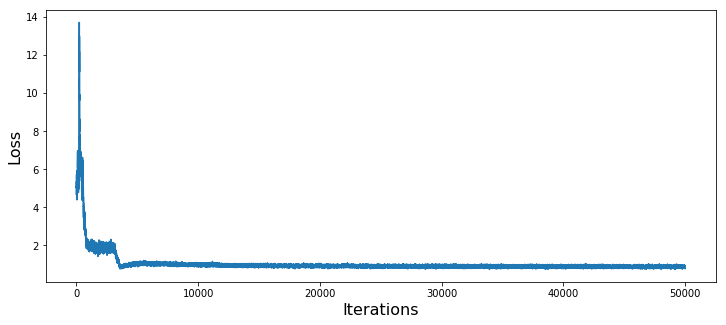

In [20]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 5))
ax.plot(loss)
ax.set_xlabel('Iterations', fontsize=16)
_ = ax.set_ylabel('Loss', fontsize=16)

## Visualize model

In [21]:
env, dataset = sample_dataset(config['maze_type'], num_samples=num_samples.value)

[ 3.95524168 -2.20377445]
[ 4.00635624 -0.37178755]
[ 2.1732235  -1.77034104]
[ 0.07888591 -2.02039838]
[ 0.20210636 -3.66558695]
[ 2.05322242 -3.96563196]
[ 1.36646283 -1.8411634 ]
[-0.03932214 -0.34061849]
[ 1.98419213 -0.20697641]
[ 3.81553125 -3.82705736]



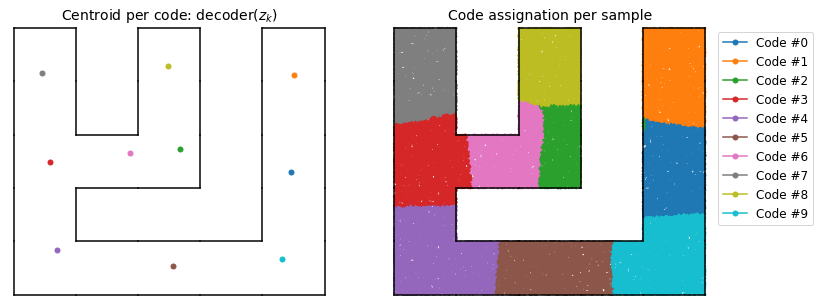

In [25]:
fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12.5, 5))

ax = axarr[0]
env.maze.plot(ax)
color_mapping = []
for emb_idx in tqdm_notebook(range(vae.codebook_size)):
    s = vae.get_centroids(dict(skill=torch.tensor(emb_idx)))[0].detach().numpy()
    print(s)
    m = ax.plot(s[0], s[1], marker='o', markersize=5, label='Code #{}'.format(emb_idx))
    color_mapping.append(m[0].get_color())
color_mapping_rgb = [list(int(h.lstrip('#')[i:i+2], 16)/255. for i in (0, 2, 4)) for h in color_mapping]
legend = ax.legend(loc='upper right', bbox_to_anchor=(2.55, 1), fontsize=12, ncol=1)
config_subplot(ax, maze_type=config['maze_type'], title="Centroid per code: $\mathrm{decoder}(z_k)$")

ax = axarr[1]
env.maze.plot(ax)
z_q_x = vae.vq.quantize(vae.encoder(dataset)).detach().numpy()
plt.scatter(dataset[:, 0], dataset[:, 1], c=[color_mapping[z] for z in z_q_x], s=3, marker='o')
config_subplot(ax, maze_type=config['maze_type'], title="Code assignation per sample")

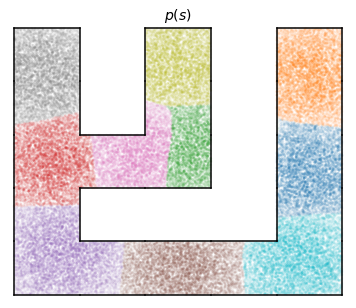

In [23]:
prob_scale = 0.1  # alpha = prob_scale * prob; tune this depending on the number of samples used (use a smaller scale when using many samples)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))
env.maze.plot(ax)
logprobs = vae.compute_logprob(dict(next_state=dataset)).detach().numpy()
rgba_colors = [color_mapping_rgb[z] + [prob_scale * prob] for z, prob in zip(z_q_x, np.exp(logprobs))]
ax.scatter(dataset[:, 0], dataset[:, 1], s=3, marker='o', c=np.array(rgba_colors))
config_subplot(ax, maze_type=config['maze_type'], title="$p(s)$")

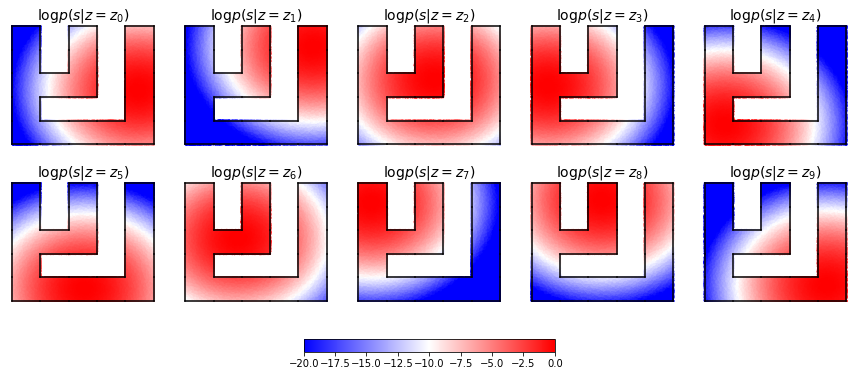

In [24]:
ncols = 5
vmin, vmax = -20, 0  # range of values to visualize

nrows = math.ceil(vae.codebook_size / ncols)
fig, axarr = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 * ncols, 3.4 * nrows))

for code_number in tqdm_notebook(range(vae.codebook_size)):
    ax = axarr.flatten()[code_number]
    env.maze.plot(ax)
    z = torch.full((len(dataset),), code_number, dtype=torch.long)
    logprobs = vae.compute_logprob_under_latent(dict(next_state=dataset, skill=z)).detach().numpy()
    sc = ax.scatter(dataset[:, 0], dataset[:, 1], s=3, marker='o', c=logprobs, vmin=vmin, vmax=vmax, cmap='bwr')
    config_subplot(ax, maze_type=config['maze_type'], title="$\logp(s|z=z_{%d})$" % code_number)
    
for idx in range(code_number + 1, len(axarr.flatten())):
    axarr.flatten()[idx].axis('off')
    
plt.subplots_adjust(hspace=0.3)
cbar = fig.colorbar(sc, ax=axarr.ravel().tolist(), shrink=0.3, orientation="horizontal", pad=0.1)